In [229]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import glob

## 
fname = r'DEEPEND_Dataset_tunas.xlsx'

df = pd.read_excel(fname,na_values=-99999)

# Getting the data without NA
tunaLarvae = df['Th_NN500'].dropna()
idx = np.where(tunaLarvae != np.nan)
sal = df['Salinity'][idx[0][:]].fillna(method='ffill')

# Removing all data based on the idx of tunaLarvae and filling the NaN regions using previous values
# removing values where salinity is greater than 40 for all variables
lat = df['Latitude (DD)'][idx[0][:]].fillna( method ='ffill') 
lat = lat[sal < 40]
lon = df['Longitude (DD)'][idx[0][:]].fillna( method ='ffill') 
lon = lon[sal < 40]
date = df['Collection date'][idx[0][:]].fillna( method ='ffill') 
date = date[sal < 40]
sst = df['SST (°C)'][idx[0][:]].fillna( method ='ffill') 
sst = sst[sal < 40]
ssh = df['SSHA (cm)'][idx[0][:]].fillna( method ='ffill') 
ssh = ssh[sal < 40]/100

tunaLarvae = tunaLarvae[sal < 40]
tuna = np.zeros((tunaLarvae.shape[0],1))
tuna[:,0] = tunaLarvae
sal = sal[sal < 40]

#################### 
Var_b = np.zeros((lat.shape[0],3))
Var_b[:,0] = sst 
Var_b[:,1] = ssh
Var_b[:,2] = sal 

Text(0.5, 0, 'time steps')

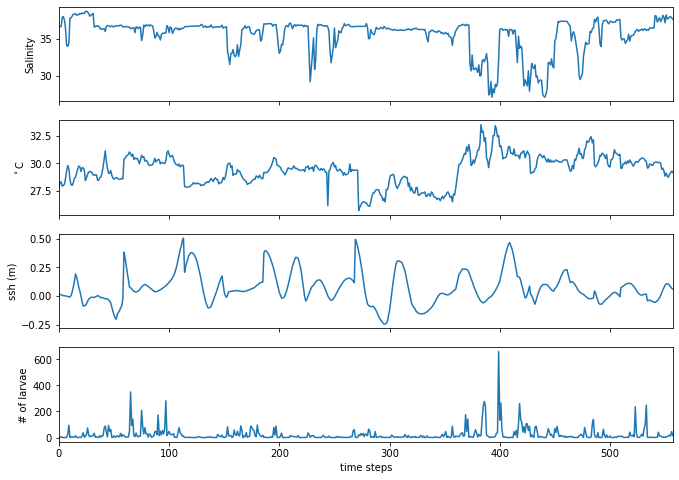

In [230]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(
    figsize=(11, 8),
    nrows=4,
    sharex=True,
)

sal.plot(ax=ax0);ax0.set_ylabel('Salinity')
sst.plot(ax=ax1);ax1.set_ylabel('$^\circ$C')
ssh.plot(ax=ax2);ax2.set_ylabel('ssh (m)')
tunaLarvae.plot(ax=ax3);ax3.set_ylabel('# of larvae');ax3.set_xlabel('time steps')

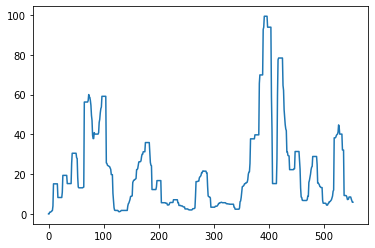

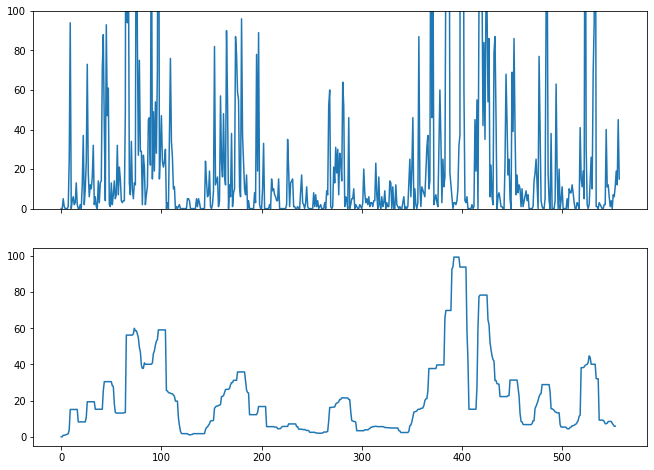

In [333]:
#%conda install bottleneck
import bottleneck as bn

def bn_mov_mean(data,width):
    return bn.move_mean(a=data,window=width,min_count = 1)

tunaSmooth = bn_mov_mean(tunaLarvae,8)

tunaVec = np.vectorize(np.int)
#tunaSmooth = tunaVec(tunaSmooth)

import scipy 
plt.plot(scipy.signal.medfilt(tunaSmooth,15))
tunaSmooth = scipy.signal.medfilt(tunaSmooth,15)

fig, (ax0, ax1) = plt.subplots(
    figsize=(11, 8),
    nrows=2,
    sharex=True,
)
ax0.plot(tunaLarvae);ax0.set_ylim(0,100)
ax1.plot(tunaSmooth)

In [352]:
from sklearn.model_selection import train_test_split

nData = 550
seed = 10

var_train, var_validation, tuna_train, tuna_validation = train_test_split(Var_b[:nData,:], tunaSmooth[:nData], test_size=0.2)#, random_state=seed) 

In [353]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
  {'n_estimators': [10, 20], 'max_features': [1,2,3]},
   # {'bootstrap': [True], 'n_estimators': [10, 20]}
    {'bootstrap': [False]},
]

forest_reg = RandomForestRegressor()

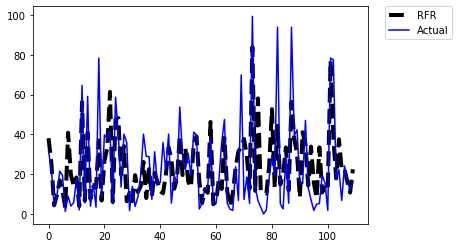

In [354]:
grid_search = GridSearchCV(forest_reg, param_grid=param_grid, cv=2)

grid_search.fit(var_train, tuna_train)

tuna_val = grid_search.predict(var_validation)

plt.plot(range(0,len(tuna_val)),tuna_val,'k--',linewidth=4,label="RFR")
plt.plot(range(0,len(tuna_validation)),tuna_validation,'b',label="Actual")  
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [355]:
grid_search.best_estimator_.feature_importances_

array([0.4215306 , 0.23806709, 0.34040232])

In [356]:
# prediction on the training dataset
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(tuna_validation, tuna_val))
rms
#train_accuracy = np.sum(np.abs(grid_search.predict(var_train) - tuna_train))/len(tuna_train)
#print('Accuracy on the train dataset is '+ str(train_accuracy))

15.274940379537343

In [357]:
# prediction on the validation dataset
val_accuracy = np.sum(np.abs(grid_search.predict(var_validation)-tuna_validation))/len(tuna_validation)
print('Accuracy on the validation dataset is '+ str(val_accuracy))

Accuracy on the validation dataset is 10.638163419913417


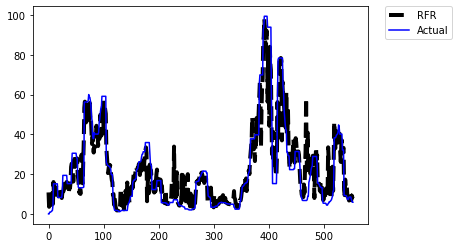

In [370]:
tuna_val = grid_search.predict(Var_b)

plt.plot(range(0,len(tuna_val)),tuna_val,'k--',linewidth=4,label="RFR")
plt.plot(range(0,len(tunaSmooth)),tunaSmooth,'b',label="Actual")  
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [350]:
rms = sqrt(mean_squared_error(tunaSmooth[nData:], tuna_val))
rms

25.136805055310777

In [12]:
#%conda install nc-time-axis

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.10
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [85]:
#!/usr/bin/env python
# coding: utf-8
import numpy as np
import pandas as pd
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import nc_time_axis
import cftime
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import warnings
warnings.simplefilter('ignore')
import datetime
import csv
import os 
import bottleneck as bn
import sys
import intake

In [86]:
def is_jj(month):
    return (month >= 6) & (month <= 7)

In [87]:
BASE = "http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/"
EXP = "ScenarioMIP/NCAR/CESM2/ssp585/r1i1p1f1/Omon/"
VAR = ["thetao" , "so" , "zos"]
GRID = "/gr/v20190730/"
#SUFFIX = ["_Omon_CESM2_ssp585_r1i1p1f1_gr_201501-206412.nc",\
#           "_Omon_CESM2_ssp585_r1i1p1f1_gr_206501-210012.nc"]
#for j in SUFFIX:

SUFFIX1 = "_Omon_CESM2_ssp585_r1i1p1f1_gr_201501-206412.nc"
SUFFIX2 = "_Omon_CESM2_ssp585_r1i1p1f1_gr_206501-210012.nc"
          
ds_surf1 = xr.Dataset()
for i in VAR:    
    url = BASE + EXP + i + GRID + i + SUFFIX1
    ds = xr.open_dataset(url)
    lat = ds['lat']
    lon = ds['lon']
    time = ds['time']
    
    try:
        surf = ds[i].sel(lev = 0, lat=slice(26,28), lon=slice(267,274))
        surf = surf.sel(time=is_jj(surf['time.month'])).mean(dim = ('lon','lat')).drop('lev')          
        surf.name = ['surf_' + i]
        ds_surf1['surf_' + i] = surf
    except:
        surf = ds[i].sel(lat=slice(26,28), lon=slice(267,274))
        surf = surf.sel(time=is_jj(surf['time.month'])).mean(dim = ('lon','lat'))
        surf.name = ['surf_' + i]
        ds_surf1['surf_' + i] = surf

ds_surf2 = xr.Dataset()
for i in VAR:    
    url = BASE + EXP + i + GRID + i + SUFFIX2
    ds = xr.open_dataset(url)
    lat = ds['lat']
    lon = ds['lon']
    time = ds['time']
    
    try:
        surf = ds[i].sel(lev = 0, lat=slice(26,28), lon=slice(267,274))
        surf = surf.sel(time=is_jj(surf['time.month'])).mean(dim = ('lon','lat')).drop('lev')          
        surf.name = ['surf_' + i]
        ds_surf2['surf_' + i] = surf
    except:
        surf = ds[i].sel(lat=slice(26,28), lon=slice(267,274))
        surf = surf.sel(time=is_jj(surf['time.month'])).mean(dim = ('lon','lat'))
        surf.name = ['surf_' + i]
        ds_surf2['surf_' + i] = surf

ds_surf = xr.auto_combine([ds_surf1, ds_surf2])

In [368]:
### Getting data ready for prediction
sstCMIP6 = ds_surf['surf_thetao'][:]
salCMIP6 = ds_surf['surf_so'][:]
sshCMIP6 = ds_surf['surf_zos'][:]

VarCMIP6 = np.zeros((sstCMIP6.shape[0],3))
VarCMIP6[:,0] = bn_mov_mean(sstCMIP6,2) 
VarCMIP6[:,1] = sshCMIP6 
VarCMIP6[:,2] = salCMIP6 

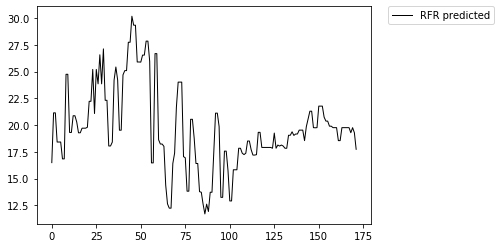

In [369]:
tuna_val = grid_search.predict(VarCMIP6)

plt.plot(range(0,len(tuna_val)),scipy.signal.medfilt(tuna_val,3),'k-',linewidth=1,label="RFR predicted") 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



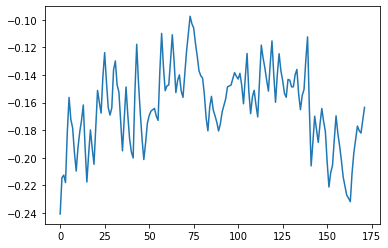

In [51]:
plt.plot(bn_mov_mean(sshCMIP6,2))

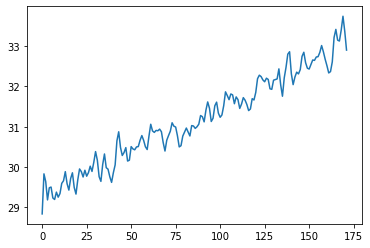

In [48]:
plt.plot(bn_mov_mean(sstCMIP6,2))

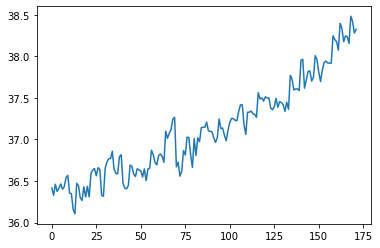

In [32]:
plt.plot(salCMIP6)